In [105]:
"""
Test Proposition 3.4 on a non-Gaussian initial with linear reference measures, using score matching.
"""
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from flax import linen as nn
from fbs.nn.utils import make_nn_with_time

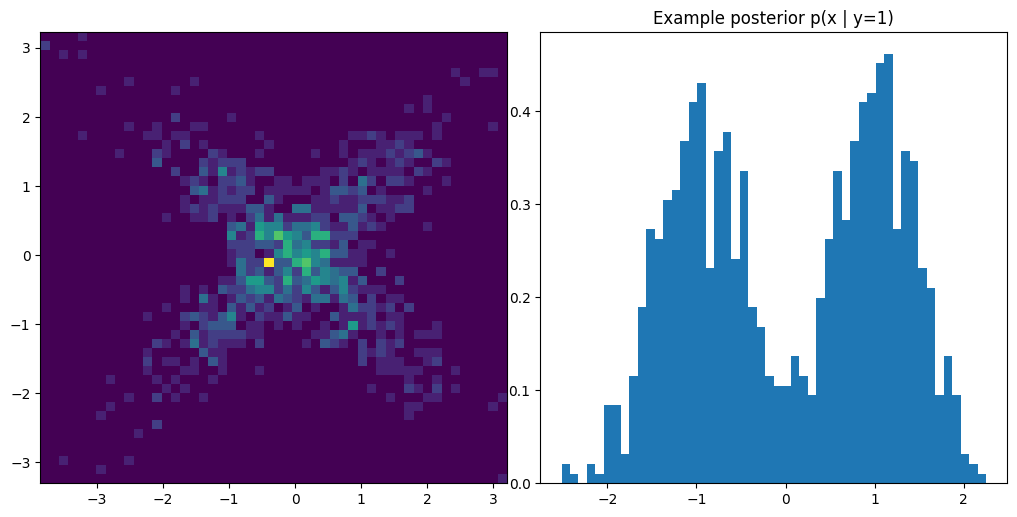

In [106]:
# General configs
nsamples = 1000
jax.config.update("jax_enable_x64", True)
nn_param_init = nn.initializers.xavier_normal()
key = jax.random.PRNGKey(666)

dt = 0.01
nsteps = 1000
T = nsteps * dt
ts = jnp.linspace(dt, T, nsteps)


# Neural network construction
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=100, param_dtype=jnp.float64, kernel_init=nn_param_init)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=20, param_dtype=jnp.float64, kernel_init=nn_param_init)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=2, param_dtype=jnp.float64, kernel_init=nn_param_init)(x)
        return jnp.squeeze(x)


mlp = MLP()
key, subkey = jax.random.split(key)
init_param, _, nn_eval = make_nn_with_time(mlp, dim_in=2, batch_size=10, key=subkey)


# Draw target model
# Define p(x | y) = N(tanh(y), log(1 + exp(y)))
# Define p(y) = N(0, 1)
# Define Z = [X, Y]
# def target_posterior_sampler(y, _key):
#     return jnp.log(1 + jnp.exp(10 * y)) * jax.random.normal(_key)

def target_posterior_sampler(y, _key):
    s1 = y + 0.5 * jax.random.normal(_key)
    _key, _subkey = jax.random.split(_key)
    s2 = -y + 0.5 * jax.random.normal(_subkey)
    _key, _subkey = jax.random.split(_key)
    return jax.random.choice(_subkey, jnp.hstack([s1, s2]))


def target_joint_sampler(_key):
    y = jax.random.normal(_key)
    _, _subkey = jax.random.split(_key)
    x = target_posterior_sampler(y, _subkey)
    return jnp.array([x, y])


key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, nsamples)
z0s = jax.vmap(target_joint_sampler, in_axes=[0])(keys)
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, nsamples)
posterior_samples = jax.vmap(target_posterior_sampler, in_axes=[None, 0])(1, keys)
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].hist2d(z0s[:, 0], z0s[:, 1], density=True, bins=50)
axes[1].hist(posterior_samples, density=True, bins=50)
axes[1].set_title('Example posterior p(x | y=1)')
plt.tight_layout(pad=0.1)
plt.show()

In [107]:
# Define the noising forward reference
# dX = -0.5 X dt + dW
# dY = -0.5 Y dt + dW2
def drift(z):
    return -0.5 * z


def simulate_forward(z0, _key):
    def scan_body(carry, elem):
        z, rnd = carry, elem
        z = jnp.exp(-0.5 * dt) * z + rnd
        return z, z

    _, _subkey = jax.random.split(_key)
    rnds = jnp.sqrt(1 - jnp.exp(-dt)) * jax.random.normal(_subkey, (nsteps, 2))
    return jax.lax.scan(scan_body, z0, rnds)[1]


def cond_pdf_z_t_0(z, t, z0):
    return jnp.sum(jax.scipy.stats.norm.logpdf(z, z0 * jnp.exp(-0.5 * t), jnp.sqrt(1 - jnp.exp(-t))))


def cond_score_t_0(z, t, z0):
    return jax.grad(cond_pdf_z_t_0)(z, t, z0)


def loss_fn(_param, _key):
    _key1, _key2 = jax.random.split(_key)
    _keys = jax.random.split(_key1, num=nsamples)
    z0s = jax.vmap(target_joint_sampler, in_axes=[0])(_keys)
    _keys = jax.random.split(_key2, num=nsamples)
    forward_paths = jax.vmap(simulate_forward, in_axes=[0, 0])(z0s, _keys)  # (nsamples, nsteps, 2)
    errs = (jax.vmap(jax.vmap(nn_eval,
                              in_axes=[0, 0, None]),
                     in_axes=[0, None, None])(forward_paths, ts, _param) -
            jax.vmap(jax.vmap(cond_score_t_0,
                              in_axes=[0, 0, None]),
                     in_axes=[0, None, 0])(forward_paths, ts, z0s)) ** 2  # (nsamples, nsteps, 2)
    return jnp.sum(jnp.mean(errs, 0))


@jax.jit
def opt_step_kernel(_param, _opt_state, _key):
    _loss, grad = jax.value_and_grad(loss_fn)(_param, _key)
    updates, _opt_state = optimiser.update(grad, _opt_state, _param)
    _param = optax.apply_updates(_param, updates)
    return _param, _opt_state, _loss


optimiser = optax.adam(learning_rate=1e-2)
opt_state = optimiser.init(init_param)
param = init_param

for i in range(500):
    key, subkey = jax.random.split(key)
    param, opt_state, loss = opt_step_kernel(param, opt_state, subkey)
    print(f'i: {i}, loss: {loss}')

i: 0, loss: 3274.736012550542
i: 1, loss: 3104.684580314456
i: 2, loss: 2486.0065025525278
i: 3, loss: 2295.7879469794734
i: 4, loss: 1945.4655581241882
i: 5, loss: 1650.999967487128
i: 6, loss: 1494.3522377055492
i: 7, loss: 1431.3338443121133
i: 8, loss: 1274.617813948582
i: 9, loss: 1144.9996760485706
i: 10, loss: 1261.5645721273818
i: 11, loss: 1316.6879483734754
i: 12, loss: 1276.8197888590757
i: 13, loss: 1203.6089995544137
i: 14, loss: 1194.7127635263992
i: 15, loss: 1205.3956337969164
i: 16, loss: 1130.94309389661
i: 17, loss: 1142.283278900451
i: 18, loss: 1109.350547003626
i: 19, loss: 1165.6343528104362
i: 20, loss: 1157.821752359986
i: 21, loss: 1131.1420149256132
i: 22, loss: 1116.728981717786
i: 23, loss: 1121.6070933389808
i: 24, loss: 1137.7266089036993
i: 25, loss: 1100.5403533505544
i: 26, loss: 1105.0942468496166
i: 27, loss: 1081.7465150731641
i: 28, loss: 1072.8754811970073
i: 29, loss: 1085.154819613171
i: 30, loss: 1086.9998171585667
i: 31, loss: 1096.97662967223

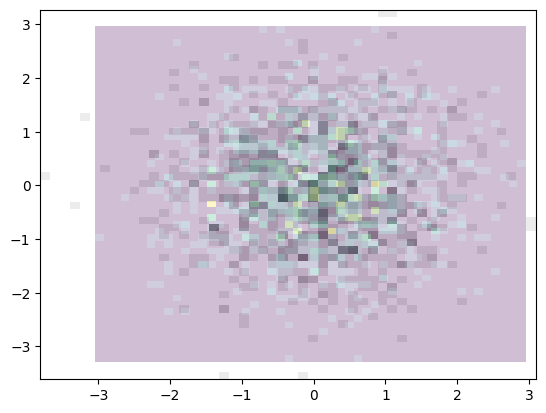

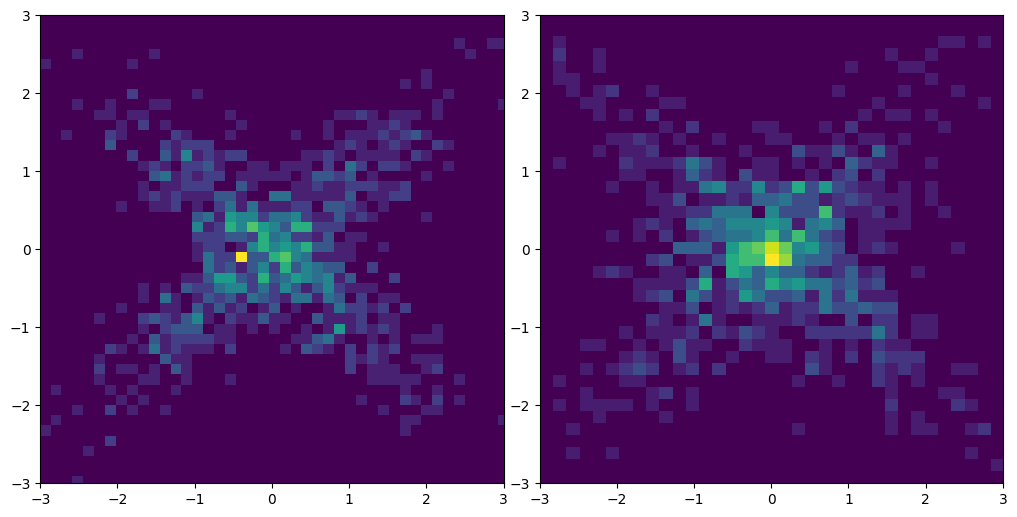

In [108]:
# Backward sampling
def simulate_backward(zT, _key):
    def scan_body(carry, elem):
        z = carry
        t, dw = elem

        z = z + (-drift(z) + nn_eval(z, T - t, param)) * dt + dw
        return z, _

    _, _subkey = jax.random.split(_key)
    dws = jnp.sqrt(dt) * jax.random.normal(_subkey, (nsteps, 2))
    return jax.lax.scan(scan_body, zT, (ts, dws))[0]


# Draw terminal samples
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num=nsamples)
paths = jax.vmap(simulate_forward, in_axes=[0, 0])(z0s, keys)
zTs = paths[:, -1]
plt.hist2d(zTs[:, 0], zTs[:, 1], density=True, bins=50, label='xT', alpha=0.5)
gaussian_samples = jax.random.normal(key, (nsamples, 2))
plt.hist2d(gaussian_samples[:, 0], gaussian_samples[:, 1], density=True, bins=50, label='xT', alpha=0.5, cmap=plt.cm.binary)
plt.show()

key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num=nsamples)
approx_x0s = jax.vmap(simulate_backward, in_axes=[0, 0])(zTs, keys)
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].hist2d(z0s[:, 0], z0s[:, 1], density=True, bins=50, label='x0')
axes[0].set_xlim([-3, 3])
axes[0].set_ylim([-3, 3])
axes[1].hist2d(approx_x0s[:, 0], approx_x0s[:, 1], density=True, bins=50, label='approx x0')
axes[1].set_xlim([-3, 3])
axes[1].set_ylim([-3, 3])
plt.tight_layout(pad=0.1)
plt.show()

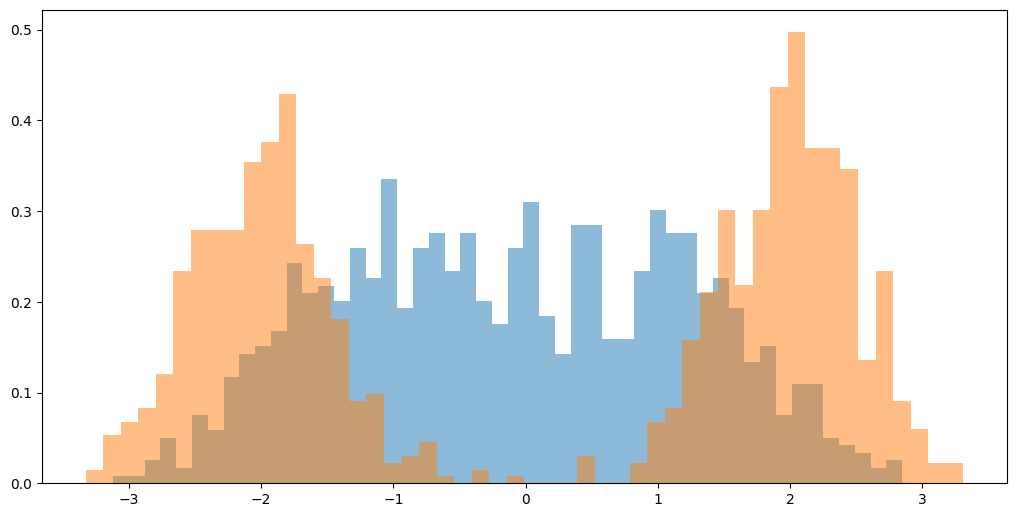

In [109]:
# Now let us check conditional sampling
y0 = 2.
z0 = jnp.array([0., y0])
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num=nsamples)
true_posterior_samples = jax.vmap(target_posterior_sampler, in_axes=[None, 0])(y0, keys)
key, subkey = jax.random.split(key)
path_y = simulate_forward(z0, subkey)[:, 1]
key, subkey = jax.random.split(key)
xTs = jax.random.normal(subkey, (nsamples,))


def simulate_backward_cond(xT, ys, _key):
    def scan_body(carry, elem):
        x = carry
        t, y, dw = elem

        z = jnp.hstack([x, y])
        x = x + (-drift(z) + nn_eval(z, T - t, param))[0] * dt + dw
        return x, _

    _, _subkey = jax.random.split(_key)
    dws = jnp.sqrt(dt) * jax.random.normal(_subkey, (nsteps,))
    return jax.lax.scan(scan_body, xT, (ts, ys[::-1], dws))[0]


key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num=nsamples)
approx_posterior_samples = jax.vmap(simulate_backward_cond, in_axes=[0, None, 0])(xTs, path_y, keys)

fig, axes = plt.subplots(ncols=1, figsize=(10, 5))
axes.hist(approx_posterior_samples, density=True, bins=50, alpha=0.5)
axes.hist(true_posterior_samples, density=True, bins=50, alpha=0.5)
plt.tight_layout(pad=0.1)
plt.show()
